## Hydra Effect

In [97]:
import os
import torch
import pickle
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
renderer = "jupyterlab"
pio.renderers.default = renderer

In [122]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(tensor.numpy(), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=tensor.numpy(), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = x.numpy()
    y = y.numpy()
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load a pickle object from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

## Load Results

In [22]:
def flatten_all_results():
    pickle_files = [f for f in os.listdir("results") if f.split(".")[-1]=="pickle"]
    results = []
    for file in pickle_files: 
        results += load_pickle("results/" + file)
    results_dict = {}
    for d in results: 
        for k,v in d.items(): 
            results_dict.setdefault(k, []).append(v)
    return results_dict

        
results = flatten_all_results()

In [27]:
results.keys()

dict_keys(['layer_names', 'clean_mle_residual_logits', 'clean_target_residual_logits', 'corrupted_mle_residual_logits', 'corrupted_target_residual_logits', 'ablated_mle_residual_logits', 'ablated_target_residual_logits', 'total_ablated_mle_logits', 'total_ablated_target_logits', 'clean_mle_logit', 'clean_target_logit', 'corrupted_mle_logit', 'corrupted_target_logit'])

In [76]:
layer_names = results["layer_names"][0]
clean_mle_residual_logits = torch.stack(results["clean_mle_residual_logits"])
clean_target_residual_logits = torch.stack(results["clean_target_residual_logits"])
corrupted_mle_residual_logits = torch.stack(results["corrupted_mle_residual_logits"])
corrupted_target_residual_logits = torch.stack(results["corrupted_target_residual_logits"])
ablated_mle_residual_logits = torch.stack(results["ablated_mle_residual_logits"])
ablated_target_residual_logits = torch.stack(results["ablated_target_residual_logits"])
total_ablated_mle_logits = torch.stack(results["total_ablated_mle_logits"])
total_ablated_target_logits = torch.stack(results["total_ablated_target_logits"])
clean_mle_logit = torch.stack(results["clean_mle_logit"])
clean_target_logit = torch.stack(results["clean_target_logit"])
corrupted_mle_logit = torch.stack(results["corrupted_mle_logit"])
corrupted_target_logit = torch.stack(results["corrupted_target_logit"])

results = {
    "layer_names": layer_names,
    "clean_mle_residual_logits": clean_mle_residual_logits,
    "clean_target_residual_logits": clean_target_residual_logits,
    "corrupted_mle_residual_logits": corrupted_mle_residual_logits,
    "corrupted_target_residual_logits": corrupted_target_residual_logits,
    "ablated_mle_residual_logits": ablated_mle_residual_logits,
    "ablated_target_residual_logits": ablated_target_residual_logits,
    "total_ablated_mle_logits": total_ablated_mle_logits,
    "total_ablated_target_logits": total_ablated_target_logits,
    "clean_mle_logit": clean_mle_logit,
    "clean_target_logit": clean_target_logit,
    "corrupted_mle_logit": corrupted_mle_logit,
    "corrupted_target_logit": corrupted_target_logit,
}


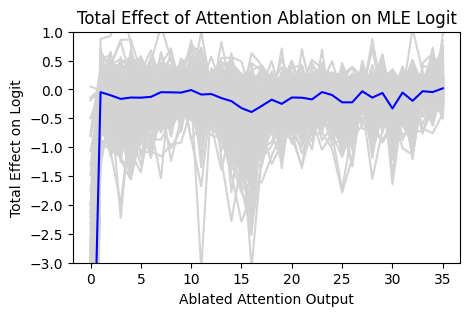

In [79]:
def plot_total_effect(results, title, ablation="attn", logit="mle"):
    if logit=="mle":
        clean_final_logit = results["clean_mle_logit"]
        ablated_final_logits = results["total_ablated_mle_logits"]                           
    elif logit=="target":
        clean_final_logit = results["clean_target_logit"]
        ablated_final_logits = results["total_ablated_target_logits"]
        
    total_effect = ablated_final_logits - clean_final_logit
    total_effect_mean = total_effect.mean(dim=0)
    
    fig = plt.figure(figsize=(5, 3))
    for te in total_effect: 
        plt.plot(te, color="lightgrey")
    plt.plot(total_effect_mean, color="blue", label="Mean")
    
    if ablation=="attn":
        xlabel = "Ablated Attention Output"
    elif ablation=="resid":
        xlabel = "Ablated Residual Stream"
    elif ablation=="mlp":
        xlabel = "Ablated MLP Output"
    
    if logit=="mle":
        ylabel = "MLE Logit"
    elif logit=="target":
        ylabel = "Target Logit"
    
    plt.title(title)
    plt.ylabel("Total Effect on Logit")
    plt.xlabel(xlabel)
    
    plt.ylim(-3, 1)
    plt.show()
    
plot_total_effect(results, title="Total Effect of Attention Ablation on MLE Logit")

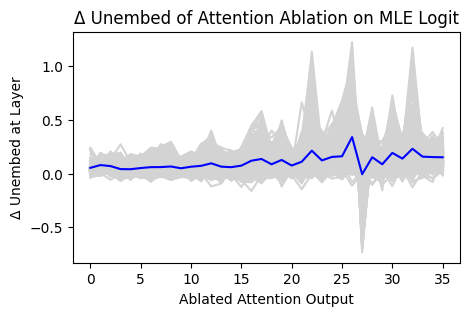

In [94]:
def plot_delta_unembed(results, title, ablation="attn", logit="mle"):
    layer_names = results["layer_names"]
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
    elif logit=="target":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        
    batch, ablation_idx, _ = ablated_residual_logits.shape
    effect_indices = torch.tensor([ablation in layer_name for layer_name in layer_names])
    # get only the effect of the ablation at the ablation index by indexing and grabbing the diagonal
    ablated_residual_logits = ablated_residual_logits[:,:,effect_indices]
    
    delta_unembed = torch.zeros((batch, ablation_idx))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
        
    delta_unembed_mean = delta_unembed.mean(dim=0)
    
    fig = plt.figure(figsize=(5, 3))
    for d in delta_unembed: 
        plt.plot(d, color="lightgrey")
    plt.plot(delta_unembed_mean, color="blue", label="Mean")
    
    if ablation=="attn":
        xlabel = "Ablated Attention Output"
    elif ablation=="resid":
        xlabel = "Ablated Residual Stream"
    elif ablation=="mlp":
        xlabel = "Ablated MLP Output"
    
    if logit=="mle":
        ylabel = "MLE Logit"
    elif logit=="target":
        ylabel = "Target Logit"
    
    plt.title(title)
    plt.ylabel("Δ Unembed at Layer")
    plt.xlabel(xlabel)
    plt.show()
    
plot_delta_unembed(results, title="Δ Unembed of Attention Ablation on MLE Logit", logit="mle")

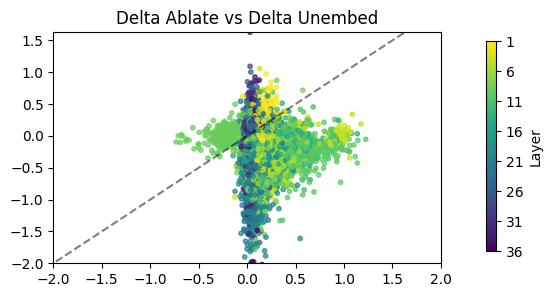

In [108]:
def plot_delta_ablate_vs_delta_unembed(results, title, ablation="attn", logit="mle"):
    layer_names = results["layer_names"]
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_final_logit = results["clean_mle_logit"]
        ablated_final_logits = results["total_ablated_mle_logits"]                           
    elif logit=="target":
        clean_final_logit = results["clean_target_logit"]
        ablated_final_logits = results["total_ablated_target_logits"]
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        
    batch, ablation_idx, _ = ablated_residual_logits.shape
    effect_indices = torch.tensor([ablation in layer_name for layer_name in layer_names])
    # get only the effect of the ablation at the ablation index by indexing and grabbing the diagonal
    ablated_residual_logits = ablated_residual_logits[:,:,effect_indices]
    delta_unembed = torch.zeros((batch, ablation_idx))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
    delta_unembed_mean = delta_unembed.mean(dim=0)
    
    delta_ablate = ablated_final_logits - clean_final_logit
    delta_ablate_mean = delta_ablate.mean(dim=0)
    
    
    #plotting
    fig = plt.figure(figsize=(5, 3))
    for i in range(batch): 
        da = delta_ablate[i]
        du = delta_unembed[i]
        layer_colors = plt.cm.viridis(np.linspace(0, 1, du.shape[-1]))
        plt.scatter(x = du, y = da, c=layer_colors, s=10, marker='o', alpha=0.7)
        
    min_val = min(delta_unembed.min(), delta_ablate.min())
    max_val = max(delta_unembed.max(), delta_ablate.max())
    
    magnitude_axis=2
    plt.xlim(-magnitude_axis, magnitude_axis)
    plt.ylim(-magnitude_axis, max_val)

    # Set the limits for the dashed line to go through zero and extend on both sides
    line_min = min(min_val, 0)
    line_max = max(max_val, 0)
    plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='dashed', alpha=0.5)
    plt.title("Delta Ablate vs Delta Unembed")
    cax = fig.add_axes([0.99, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), cax=cax)
    tick_locations = np.linspace(0, 1, 8)  # Adjust the number of ticks as needed
    tick_labels = np.arange(36, 0, -5)
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Layer')

    
plot_delta_ablate_vs_delta_unembed(results, title="Δ Unembed of Attention Ablation on MLE Logit", logit="mle")

In [106]:
def plot_variance_delta_ablate_vs_delta_unembed(results, title, ablation="attn", logit="mle"):
    layer_names = results["layer_names"]
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_final_logit = results["clean_mle_logit"]
        ablated_final_logits = results["total_ablated_mle_logits"]                           
    elif logit=="target":
        clean_final_logit = results["clean_target_logit"]
        ablated_final_logits = results["total_ablated_target_logits"]
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        
    batch, ablation_idx, _ = ablated_residual_logits.shape
    effect_indices = torch.tensor([ablation in layer_name for layer_name in layer_names])
    # get only the effect of the ablation at the ablation index by indexing and grabbing the diagonal
    ablated_residual_logits = ablated_residual_logits[:,:,effect_indices]
    delta_unembed = torch.zeros((batch, ablation_idx))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
    
    delta_ablate = ablated_final_logits - clean_final_logit

    delta_ablate_mean = delta_ablate.mean(dim=0)
    delta_unembed_mean = delta_unembed.mean(dim=0)
    
    total_variance = delta_ablate.var(dim=0) #* (delta_ablate.shape[0] - 1)
    
    print(total_variance)


plot_variance_delta_ablate_vs_delta_unembed(results, title="Δ Unembed of Attention Ablation on MLE Logit", logit="mle")

tensor([7.1765, 0.0489, 0.0576, 0.0810, 0.0835, 0.0553, 0.0474, 0.0401, 0.0329,
        0.0291, 0.0335, 0.0628, 0.0275, 0.0499, 0.0887, 0.1127, 0.1917, 0.0591,
        0.0376, 0.0574, 0.0291, 0.0373, 0.0327, 0.0337, 0.0300, 0.0690, 0.0429,
        0.0194, 0.0538, 0.0298, 0.0674, 0.0174, 0.0567, 0.0114, 0.0225, 0.0481])


In [163]:
def plot_ablate_idx_x_effect_idx_sum(results, title, ablation="attn", logit="mle", idx_of_interest="all"):
    idx_of_interest = "_" if idx_of_interest=="all" else idx_of_interest
    layer_names = results["layer_names"]
    
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_final_logit = results["clean_mle_logit"]
        ablated_final_logits = results["total_ablated_mle_logits"]  
        clean_residual_logits = results["clean_mle_residual_logits"]    
        corrupted_residual_logits = results["corrupted_mle_residual_logits"]                     
    elif logit=="target":
        clean_final_logit = results["clean_target_logit"]
        ablated_final_logits = results["total_ablated_target_logits"]
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_residual_logits = results["clean_target_residual_logits"]
        corrupted_residual_logits = results["corrupted_target_residual_logits"]
        
    batch, ablation_idx, effect_idx = ablated_residual_logits.shape
        
    ablation_mask = torch.tensor([ablation in l for l in layer_names])
    effect_mask = torch.tensor([idx_of_interest in l for l in layer_names])
        
    ablated_residual_logits = ablated_residual_logits[:,:,effect_mask]
    clean_residual_logits = clean_residual_logits[:,effect_mask]
    corrupted_residual_logits = corrupted_residual_logits[:,effect_mask]
    
    direct_effect = torch.zeros((batch, ablation_idx))
    for i in range(batch):
        direct_effect[i] = torch.diagonal(ablated_residual_logits[i]) - clean_residual_logits[i]
    # direct_effect = corrupted_residual_logits[:,effect_mask] - clean_residual_logits
         
    # compensatory_effect = (ablated_residual_logits-corrupted_residual_logits.unsqueeze(-1)) 
    # compensatory_effect = direct_effect.unsqueeze(-1)
    
    compensatory_effect = ablated_residual_logits - clean_residual_logits.unsqueeze(-1)
    
    
    
    compensatory_effect = compensatory_effect.mean(dim=0)
    
    
    disp_layer_names = [l for l in layer_names if idx_of_interest in l]

    imshow(compensatory_effect,y=disp_layer_names,labels={"x":"Ablation Index", "y":"Layer"}, title="PLOT A")
    
plot_ablate_idx_x_effect_idx_sum(results,
                                 title="Δ Unembed of Attention Ablation on MLE Logit", logit="mle", 
                                 idx_of_interest="attn")